# Importing Libraries and Cleaned Datasets

In [26]:
#import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm

county_health_rank = pd.read_csv('county_rankings25.csv')
fips_codes = pd.read_csv('all_fips.csv')
county_vars = pd.read_csv('county_vars_2.csv')
ltss_2022 = pd.read_csv('ltss_2022.csv')
race_groups = pd.read_csv('agg_race_variables.csv')

# Data Cleaning Plan
## County Health Rankings 2025
In place of the previousl 4 tables reporting socio economic metrics, I found a new Dataset 'County Health Rankings.' The data wrangling process will involve selecting the target variables, renaming, normalizing data types, validating the resulting dataframe, and applying the standardized hierarchical index (county, state).

Since dataset contains hundreds of variables, I created a small dataframe of our variables of interest and normalized names to facilate creating the subset itself and its naming conventions. 


## LTSS Enrollment and Expenditure tables
The state-level LTSS enrollment and expenditure tables remain and their cleaning involves: subsetting by columns neeeded reporting metrics for enrollment and expenses. These variables reflect enrollment in the first table and expenses in the second for (1)The entire LTSS program, (2) Institutional care, and (3)HCBS program. 

I will subset each table by thsese colums, rename by the conventions defined at the beginning of the section, remove invalid characters ('$', ',') from numeric columns, change the datatypes of the columns to floats for quantitative variables ans strings for 'id' variables, and set 'state' as index prior to merging.

## FIPS & States ID table
I will merge both tables above to a previosly created 'all_fips' (which serves as a sort of  'fact table'-listing county names, state names, state abbreviations, and corresponding fips codes) by index. 

I will validate the data and clean any merging errors like the creation of duplicate columns and/or changes to naming conventions (such as adding suffixes/prefixes to duplicate and original colums).

Finally, I will merge both of these new tables by the standardized index mentioned above.

# Data Cleaning

## LTSS Table

### Cleaning invalid characters in columns to prep for datatype conversion to float

In [ ]:
# defining columns to keep and subsetting dataframes
ltss_cols= ['State', 'LTSS (total)']
ltss_population = ltss_2022[ltss_cols]

ltss_population['LTSS (total)'] = ltss_population['LTSS (total)'].str.replace(',', '').astype(float)
ltss_pop_names = {'State': 'state', 'LTSS (total)': 'ltss_state_enrollment'}
ltss_population = ltss_population.rename(columns=ltss_pop_names)
ltss_population.set_index(['state'])
# normalize state names
ltss_state_rename_enr = {'National': 'United States','District of\nColumbia':'District of Columbia'}
ltss_population['state'] = ltss_population['state'].replace(ltss_state_rename_enr)


## County Rankings tables

create subset, clean result, and merge with 'fips_codes'

In [27]:
county_health_subset = county_vars['raw_variable'].tolist()
new_names = county_vars[' new_name'].tolist()
county_health_cols = dict(zip(county_health_subset, new_names))
# creating subset and renaiming with list and dictionary from above
county_health= county_health_rank[county_health_subset]
county_health= county_health.rename(columns=county_health_cols)
# normalizing fips codes
county_health['fips'] = county_health['fips'].astype('str')
fips_codes['fips'] = fips_codes['fips'].astype('str')
#merging with fips codes
us_counties = pd.merge(county_health, fips_codes, how='outer', on='fips')
# creating new dataframe without non-county data to keep original dataframe for 'non_county' data subset
us_counties_updated = us_counties.dropna(subset=['state'])
# these are states, the US, and 'planning' regions
non_counties = us_counties[us_counties['state'].isnull()]

### clean new table

In [28]:
def clean_merge(us_counties_updated):
    # Drop columns: 'county_x', 'state_abbr_x'
    us_counties_updated = us_counties_updated.drop(columns=['county_x', 'state_abbr_x'])
    # Rename column 'county_y' to 'county'
    us_counties_updated = us_counties_updated.rename(columns={'county_y': 'county'})
    # Rename column 'state_abbr_y' to 'state_abbr'
    us_counties_updated = us_counties_updated.rename(columns={'state_abbr_y': 'state_abbr'})
    return us_counties_updated

In [29]:
us_counties_updated = clean_merge(us_counties_updated)
us_counties_updated = us_counties_updated.round(2)

## Drill down subsets

In [30]:
racial_category_subset = race_groups['raw_variable'].tolist()
racial_category_names = race_groups['new_name'].tolist()
racial_category_cols = dict(zip(racial_category_subset, racial_category_names))
race_categories = county_health_rank[racial_category_subset]

# cleaning new df:renaming with list and dictionary from above, changing dytypes, and rounding
race_categories= race_categories.rename(columns=racial_category_cols)
race_categories['fips'] = race_categories['fips'].astype('str')
race_categories = race_categories.round(2)
race_categories =race_categories.fillna(0)

In [31]:
race_categories.head()

,fips,county,state_abbr,child_poverty-aian,child_poverty-black,child_poverty-hispanic,child_poverty-white,life_expectancy-white,life_expectancy-nhopi,life_expectancy-hispanic,...,firearm_fatalities-black,firearm_fatalities-hispanic,firearm_fatalities-white,firearm_fatalities-nhopi,population-aian,population-asian,population-hispanic,population-black,population-white,population-nhopi
0,0,United States,US,0.28,0.30,0.22,0.10,77.19,76.42,79.73,...,30.60,8.00,12.76,9.78,0.01,0.06,0.19,0.13,0.58,0.0
1,1000,Alabama,AL,0.28,0.38,0.33,0.12,73.92,76.98,92.28,...,38.12,8.98,19.85,0.00,0.01,0.02,0.06,0.26,0.64,0.0
2,1001,Autauga County,AL,0.00,0.26,0.22,0.08,75.29,0.00,0.00,...,20.67,0.00,17.66,0.00,0.00,0.01,0.04,0.21,0.71,0.0
3,1003,Baldwin County,AL,0.00,0.54,0.34,0.07,76.72,0.00,98.14,...,24.46,0.00,15.08,0.00,0.01,0.01,0.06,0.08,0.82,0.0
4,1005,Barbour County,AL,0.00,0.49,0.60,0.04,74.20,0.00,0.00,...,30.51,0.00,24.90,0.00,0.01,0.01,0.06,0.46,0.45,0.0


## Multi-Index Tables for drill down

### Reshape df

#### Function to create social metric race sub-categories

In [32]:
# Step 1: Melt the dataframe to long format
rc_long = race_categories.melt(
    id_vars=['state_abbr', 'county', 'fips'], 
    var_name='metric_race', 
    value_name='value'
)

# Step 2: Split the combined 'metric_ethnicity' column
rc_long[['metric', 'race']] = rc_long['metric_race'].str.extract(r'(.+?)-(.+)')

# Step 3: Drop the original combined column
rc_long = rc_long.drop(columns='metric_race')

# Step 4: Pivot to have metrics as columns
race_metrics = rc_long.pivot_table(
    index=['state_abbr', 'county', 'fips', 'race'],
    columns='metric',
    values='value'
).reset_index()

# Step 5: Optional - Set a MultiIndex for hierarchical indexing


# Step 6: (Optional) Clean up column names if needed
race_metrics.columns.name = None


In [33]:
race_metrics.reset_index()

,index,state_abbr,county,fips,race,child_mortality,child_poverty,firearm_fatalities,life_expectancy,median_income,population,premature_death
0,0,AK,Alaska,2000,aian,159.03,0.24,38.76,65.14,59090.0,0.16,23949.55
1,1,AK,Alaska,2000,asian,43.39,NaN,7.62,85.57,90314.0,0.07,4497.75
2,2,AK,Alaska,2000,black,47.33,0.34,26.64,75.81,73780.0,0.03,8895.28
3,3,AK,Alaska,2000,hispanic,45.50,0.12,15.11,85.03,74456.0,0.07,5566.66
4,4,AK,Alaska,2000,nhopi,93.24,NaN,27.82,67.39,NaN,0.02,19362.04
...,...,...,...,...,...,...,...,...,...,...,...,...
19219,19219,WY,Wyoming,56000,asian,0.00,NaN,0.00,82.97,65260.0,0.01,2433.45
19220,19220,WY,Wyoming,56000,black,0.00,0.42,0.00,72.87,40750.0,0.01,13836.66
19221,19221,WY,Wyoming,56000,hispanic,52.85,0.17,9.30,77.28,63542.0,0.11,8022.13
19222,19222,WY,Wyoming,56000,nhopi,0.00,NaN,0.00,0.00,NaN,0.00,0.00


### Clean up new dataframe

In [ ]:
# get list of state names to remove from county column
state_names = fips_codes['state'].unique()
state_names = state_names.tolist()
race_metrics = race_metrics[~race_metrics['county'].isin(state_names)]
race_metrics.set_index(['state_abbr', 'county', 'fips', 'race'], inplace=True)
race_metrics = race_metrics.fillna(0)

# Insights

## Basic Descriptive Stats

In [ ]:

sorted_unagg = us_counties_updated.sort_values(by=['state_abbr', 'county'])
sorted_unagg.drop_duplicates(subset='fips', keep='last', inplace=True)
#sorted_unagg.set_index(['state_abbr', 'county', 'fips'], inplace=True)


hs_diploma_percentage  \
state_abbr county            fips                           
WY         Sweetwater County 56037                   0.93   
           Teton County      56039                   0.97   
           Uinta County      56041                   0.95   
           Washakie County   56043                   0.91   
           Weston County     56045                   0.92   

                                    unemployed_percentage  population   \
state_abbr county            fips                                        
WY         Sweetwater County 56037                   0.03      41249.0   
           Teton County      56039                   0.02      23232.0   
           Uinta County      56041                   0.03      20745.0   
           Washakie County   56043                   0.03       7710.0   
           Weston County     56045                   0.02       6808.0   

                                    median_income  school_segration_index  \
state_abbr county            fips                                           
WY         Sweetwater County 56037        76442.0                    0.03   
           Teton County      56039       130156.0                    0.08   
           Uinta County      56041        79086.0                    0.05   
           Washakie County   56043        62794.0                    0.04   
           Weston County     56045        66429.0                    0.02   

                                    gender_pay_gap  uninsured__percentage  \
state_abbr county            fips                                           
WY         Sweetwater County 56037            0.64                   0.13   
           Teton County      56039            0.88                   0.15   
           Uinta County      56041            0.63                   0.14   
           Washakie County   56043            0.75                   0.15   
           Weston County     56045            0.51                   0.15   

                                    school_funding_gap  \
state_abbr county            fips                        
WY         Sweetwater County 56037             6757.30   
           Teton County      56039            12821.90   
           Uinta County      56041             7141.45   
           Washakie County   56043            13314.79   
           Weston County     56045             4071.35   

                                    residential_segregation  premature_death  \
state_abbr county            fips                                              
WY         Sweetwater County 56037                    74.18         10209.65   
           Teton County      56039                      NaN          4173.60   
           Uinta County      56041                      NaN         10947.03   
           Washakie County   56043                      NaN          9591.28   
           Weston County     56045                      NaN          6754.81   

                                    income_inequality  child_poverty  \
state_abbr county            fips                                      
WY         Sweetwater County 56037               4.53           0.12   
           Teton County      56039               4.01           0.06   
           Uinta County      56041               3.67           0.11   
           Washakie County   56043               4.77           0.17   
           Weston County     56045               4.17           0.14   

                                    life_expectancy  child_mortality  \
state_abbr county            fips                                      
WY         Sweetwater County 56037            74.63            61.74   
           Teton County      56039            87.58            66.92   
           Uinta County      56041            74.95            65.02   
           Washakie County   56043            76.07              NaN   
           Weston County     56045            78.00              NaN   

                               

In [56]:
sorted_unagg.describe()

,hs_diploma_percentage,unemployed_percentage,population,median_income,school_segration_index,gender_pay_gap,uninsured__percentage,school_funding_gap,residential_segregation,premature_death,income_inequality,child_poverty,life_expectancy,child_mortality,high_housing_cost_percentage,firearm_fatalities,child_care_cost_burden
count,3131.000000,3138.000000,3.131000e+03,3130.000000,2918.000000,3122.000000,3130.000000,3052.000000,2055.000000,3086.000000,3110.000000,3130.000000,3066.000000,2047.000000,3131.000000,2295.000000,3137.000000
mean,0.887595,0.035905,1.058022e+05,65489.399042,0.082087,0.786477,0.104818,-470.978545,49.466891,10380.437910,4.558839,0.190019,75.152926,64.606453,0.099764,17.800684,0.285891
std,0.054812,0.012210,3.325502e+05,16485.071600,0.075295,0.102182,0.046595,6814.750292,16.650059,3785.973079,0.810819,0.080513,3.607773,25.816667,0.033706,8.390924,0.070401
min,0.470000,0.000000,4.300000e+01,28579.000000,0.000000,0.380000,0.020000,-46776.990000,1.440000,3315.250000,2.270000,0.030000,53.980000,19.010000,0.000000,1.860000,0.120000
25%,0.860000,0.030000,1.075550e+04,54610.750000,0.030000,0.730000,0.070000,-3054.647500,38.230000,7733.415000,4.020000,0.130000,72.782500,47.065000,0.080000,12.110000,0.230000
50%,0.900000,0.030000,2.594400e+04,62771.000000,0.060000,0.790000,0.090000,20.215000,50.400000,9824.240000,4.420000,0.180000,75.270000,59.830000,0.100000,16.640000,0.280000
75%,0.930000,0.040000,6.881600e+04,73022.000000,0.110000,0.840000,0.130000,2606.035000,60.765000,12367.902500,4.957500,0.230000,77.537500,75.565000,0.120000,21.995000,0.330000
max,1.000000,0.170000,9.663345e+06,173655.000000,0.640000,1.870000,0.380000,35429.370000,92.420000,46417.850000,10.500000,0.630000,94.220000,326.690000,0.300000,79.460000,0.650000


## Correlation and distributions

### Aggregate Data

<Axes: >

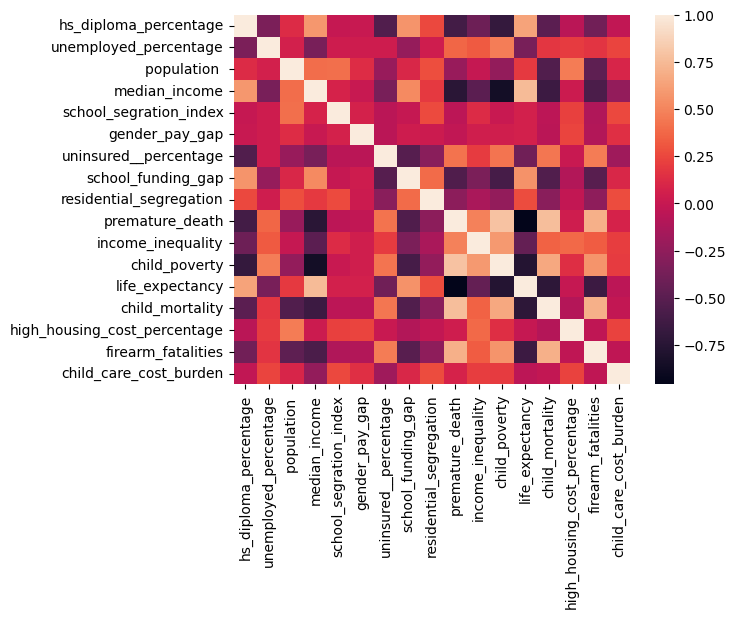

In [57]:
matrix = us_counties_updated.corr(method='spearman', numeric_only=True).round(2)
sns.heatmap(matrix)

In [54]:
us_counties_updated['population '] = us_counties_updated['population '].rename('population')

### Probability distributions

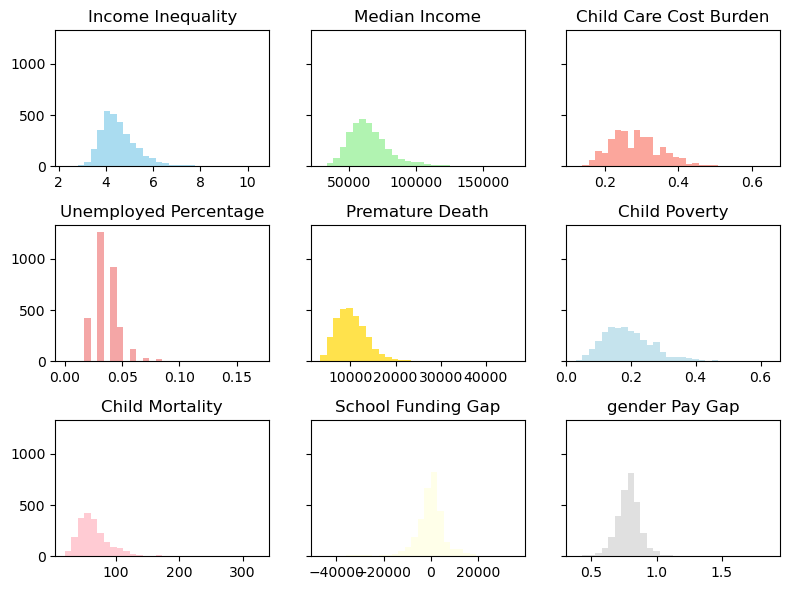

In [65]:
fig, axes = plt.subplots(3, 3, figsize=(8, 6), sharey=True)

axes[0, 0].hist(us_counties_updated['income_inequality'], bins=30, color='skyblue', alpha=0.7)
axes[0, 1].hist(us_counties_updated['median_income'], bins=30, color='lightgreen', alpha=0.7)
axes[0, 2].hist(us_counties_updated['child_care_cost_burden'], bins=30, color='salmon', alpha=0.7)
axes[1, 0].hist(us_counties_updated['unemployed_percentage'], bins=30, color='lightcoral', alpha=0.7)
axes[1, 1].hist(us_counties_updated['premature_death'], bins=30, color='gold', alpha=0.7)
axes[1, 2].hist(us_counties_updated['child_poverty'], bins=30, color='lightblue', alpha=0.7)
axes[2, 0].hist(us_counties_updated['child_mortality'], bins=30, color='lightpink', alpha=0.7)
axes[2, 1].hist(us_counties_updated['school_funding_gap'], bins=30, color='lightyellow', alpha=0.7)
axes[2, 2].hist(us_counties_updated['gender_pay_gap'], bins=30, color='lightgray', alpha=0.7)

axes[0, 0].set_title('Income Inequality')
axes[0, 1].set_title('Median Income')
axes[0, 2].set_title('Child Care Cost Burden')
axes[1, 0].set_title('Unemployed Percentage')
axes[1, 1].set_title('Premature Death')
axes[1, 2].set_title('Child Poverty')
axes[2, 0].set_title('Child Mortality')
axes[2, 1].set_title('School Funding Gap')
axes[2, 2].set_title('gender Pay Gap')
plt.tight_layout()
plt.show()

## Drill down on race

In [77]:
race_subset = race_metrics.dropna

/home/mapsg/miniconda3/envs/pydata/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mapsg/miniconda3/envs/pydata/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mapsg/miniconda3/envs/pydata/lib/python3.13/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/mapsg/miniconda3/envs/pydata/lib/python

<Axes: xlabel='child_poverty', ylabel='Count'>

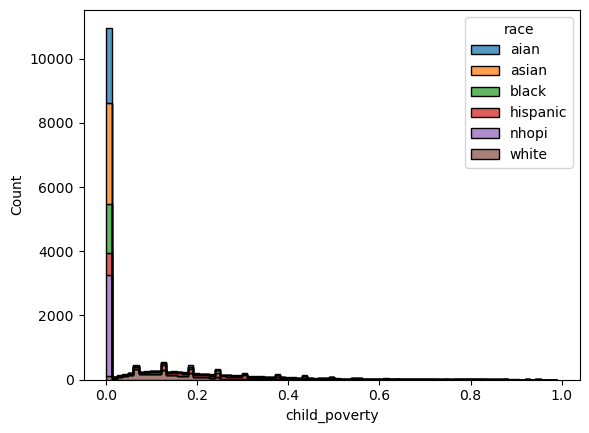

In [79]:
sns.histplot(data=race_metrics, x='child_poverty', hue='race', multiple='stack', element='step')

In [71]:
race_metrics.head()

child_mortality  \
state_abbr county                 fips race                        
AK         Aleutians East Borough 2013 aian                  0.0   
                                       asian                 0.0   
                                       black                 0.0   
                                       hispanic              0.0   
                                       nhopi                 0.0   

                                                 child_poverty  \
state_abbr county                 fips race                      
AK         Aleutians East Borough 2013 aian               0.26   
                                       asian              0.00   
                                       black              0.00   
                                       hispanic           0.00   
                                       nhopi              0.00   

                                                 firearm_fatalities  \
state_abbr county                 fips race                           
AK         Aleutians East Borough 2013 aian                     0.0   
                                       asian                    0.0   
                                       black                    0.0   
                                       hispanic                 0.0   
                                       nhopi                    0.0   

                                                 life_expectancy  \
state_abbr county                 fips race                        
AK         Aleutians East Borough 2013 aian                  0.0   
                                       asian                 0.0   
                                       black                 0.0   
                                       hispanic              0.0   
                                       nhopi                 0.0   

                                                 median_income  population  \
state_abbr county                 fips race                                  
AK         Aleutians East Borough 2013 aian            52237.0        0.13   
                                       asian           96726.0        0.44   
                                       black               0.0        0.09   
                                       hispanic        81818.0        0.21   
                                       nhopi               0.0        0.01   

                                                 premature_death  
state_abbr county                 fips race                       
AK         Aleutians East Borough 2013 aian             32661.18  
                                       asian                0.00  
                                       black                0.00  
                                       hispanic             0.00  
                                       nhopi                0.00

### Comparing distributions between income inequality groupings: 'above_median' and 'below_median'

In [66]:
print(us_counties_updated['income_inequality'].median())

4.42
